## 1.导入数据

In [78]:
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi']
import warnings 
warnings.filterwarnings("ignore")
plt.rcParams['axes.unicode_minus']=False
# Load the Excel file
data = pd.read_excel(r"C:\Users\hp\Desktop\业绩-调任表.xlsx")

## 2.标识调职日期（BOOL）、得分(float)

- data_cleaned：包含每个战区及其在每个月的业绩得分（0、1、2）
- managerial_change：布尔数据框，显示在哪个月有高管调职

In [79]:
# Create a new dataframe to hold the boolean values of whether there was a managerial change
managerial_change = data.iloc[:, 1:].applymap(lambda x: isinstance(x, str) and '*' in x)

# Remove '*' from the original dataframe and convert the data to numeric
data_cleaned = data.copy()
data_cleaned.iloc[:, 1:] = data.iloc[:, 1:].applymap(lambda x: str(x).replace('*', '')).astype(float)
# mnagerial_change.head()
# data_cleaned.head()

# 3.消极因子和有效性
- 根据每三个月的周期，将数据分割成若干个子数据集。
- 计算每个子数据集的平均得分，以此来评估这三个月的整体业绩。
- 根据是否有高管调职，为每个三个月的周期打上标记。

## 3.1 各战区平均消极因子
- 消极因子越大，代表调职对该战区的负面影响越大

In [80]:
# Split the data into periods of 3 months
periods = list(range(0, data_cleaned.shape[1]-1, 3))
# Calculate the average score for each period
averages = []
for i in range(len(periods)-1):
    start, end = periods[i]+1, periods[i+1]+1
    avg = data_cleaned.iloc[:, start:end].mean(axis=1)
    averages.append(avg)
# Concatenate averages into a dataframe
average_scores = pd.concat(averages, axis=1)
# Rename columns to represent periods
columns = [f"Period_{i+1}" for i in range(len(averages))]
average_scores.columns = columns
average_scores = pd.concat([data_cleaned['战区'], average_scores], axis=1)
average_scores.head()

,战区,Period_1,Period_2,Period_3,Period_4,Period_5
0,集团,0.666667,0.000000,0.000000,0.333333,0.666667
1,湖南战区,1.000000,0.000000,0.000000,0.000000,0.000000
2,甘宁战区,0.000000,0.000000,0.333333,0.333333,0.666667
3,安徽战区,0.333333,0.666667,1.000000,1.666667,1.333333
4,陕西战区,1.333333,0.333333,0.000000,0.333333,0.000000


## 3.2 设计有效性指标

- 结合业绩得分和高管调职的数据来进行深入的分析
- 得到每个战区在每个三月评估周期内的平均业绩得分和是否有高管调职的指标

接下来，为了评估高管调职后的业绩变化，**有效性**定义如下：

- 对于有高管调职的周期，观察下一个周期的业绩得分是否有所改善。
- 如果下一个周期的消极因子比当前周期低，则有效性为负；如果消极因子相同，则有效性为零；如果消极因子更高，则有效性为正。
$$有效性=(下一个周期的得分−当前周期的得分) * BOOL值$$
- 解释bool
这样，我们可以为每个战区和每个周期计算一个有效性得分。

In [81]:
# Modifying the provided code to correctly compute the effectiveness score for the last period

# Calculate effectiveness for each period
# Check if there was a managerial change in each period
managerial_changes = []
for i in range(len(periods)-1):
    start, end = periods[i]+1, periods[i+1]+1
    change = managerial_change.iloc[:, start:end].any(axis=1)
    managerial_changes.append(change)

# Concatenate managerial change indicators into a dataframe
managerial_change_periods = pd.concat(managerial_changes, axis=1)
managerial_change_periods.columns = columns
managerial_change_periods = pd.concat([data_cleaned['战区'], managerial_change_periods], axis=1)

effectiveness = average_scores.copy().iloc[:, 1:]
for i in range(len(columns)):
    current_period = average_scores[columns[i]]
    
    # If it's the last column, the next period will be NaN
    if i == len(columns) - 1:
        next_period = float('NaN')
        # Calculate the score considering only the change within the last period
        last_period_scores = data_cleaned.iloc[:, -3:].mean(axis=1) - data_cleaned.iloc[:, -4:-1].mean(axis=1)
        change_last_period = managerial_change_periods[columns[i]]
        effectiveness[columns[i]] = change_last_period * last_period_scores
    else:
        next_period = average_scores[columns[i+1]]
        change = managerial_change_periods[columns[i]]
        # Calculate effectiveness
        effectiveness[columns[i]] = change * (next_period - current_period)

# Concatenate with the '战区' column
effectiveness = pd.concat([data_cleaned['战区'], effectiveness], axis=1)
effectiveness.head()

,战区,Period_1,Period_2,Period_3,Period_4,Period_5
0,集团,-0.0,0.000000,0.000000,0.000000,-0.000000
1,湖南战区,-0.0,0.000000,0.000000,0.000000,0.666667
2,甘宁战区,0.0,0.000000,0.000000,0.333333,-0.000000
3,安徽战区,0.0,0.000000,0.000000,-0.000000,0.000000
4,陕西战区,-1.0,-0.333333,0.333333,-0.000000,0.000000


# 4.结果可视化

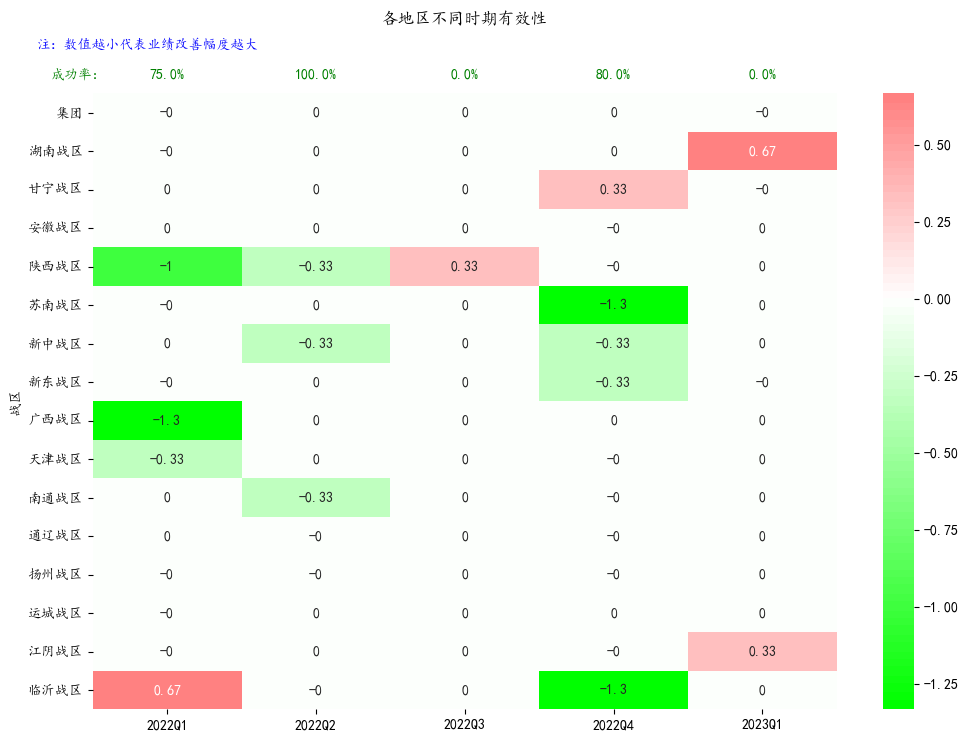

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# 创建自定义颜色映射
colors = [(0, 1, 0), (1, 1, 1), (1, 0, 0)]  # G -> W -> R
n_bins = [3]  # Discretizes the interpolation into bins
cmap_name = 'custom_divergence'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=100)
# Correctly calculate the success rates excluding values that are 0 (white cells in heatmap)

heatmap_data = effectiveness.drop(columns=['战区']).set_index(effectiveness['战区'])[:-3]
heatmap_data.columns,columns1 = ['2022Q1','2022Q2','2022Q3','2022Q4','2023Q1'],['2022Q1','2022Q2','2022Q3','2022Q4','2023Q1']

success_rates_exact = {}
for column in columns1:
    total_events = (heatmap_data[column] != 0).sum()  # Count non-zero values (excluding white cells)
    successful_events = (heatmap_data[column] < 0).sum()
    success_rate = successful_events / total_events if total_events != 0 else 0
    success_rates_exact[column] = success_rate

# Recreate the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap=cm, annot=True, center=0)
plt.title("各地区不同时期有效性", y=1.1)  # Adjust title position to avoid overlap

# Add "成功率：" label on the left
plt.text(-0.1, -0.5, "成功率：", ha='center', va='center', color='green', fontsize=10)

# Add exact success rates next to the "成功率：" label
for i, column in enumerate(columns1):
    rate = round(success_rates_exact[column] * 100, 2)
    plt.text(i+0.5, -0.5, f"{rate}%", ha='center', va='center', color='green', fontsize=10)

# Annotate the heatmap
plt.annotate('注：数值越小代表业绩改善幅度越大', xy=(0,1), xytext=(-40, 40),
             xycoords='axes fraction', textcoords='offset points',
             va='top', fontsize=10, color='blue')
plt.show()

##  热力图分析
- 各阶段调职成功率较高
- 第三、五个周期，成功率为0，原因是该周期内离职事件太少，产生的偶然性
- 我们可以算出总成功率=绿色方块数/总方块数=(10/15）=$\frac{2}{3}=67\%$

这是每个战区在每个三月评估周期的有效性得分的热图。
- 正值（红色）表示在下一个周期中业绩消极因子有所提高，
- 负值（蓝色）表示业绩消极因子下降，
- 而零值（白色）表示业绩消极因子保持不变。

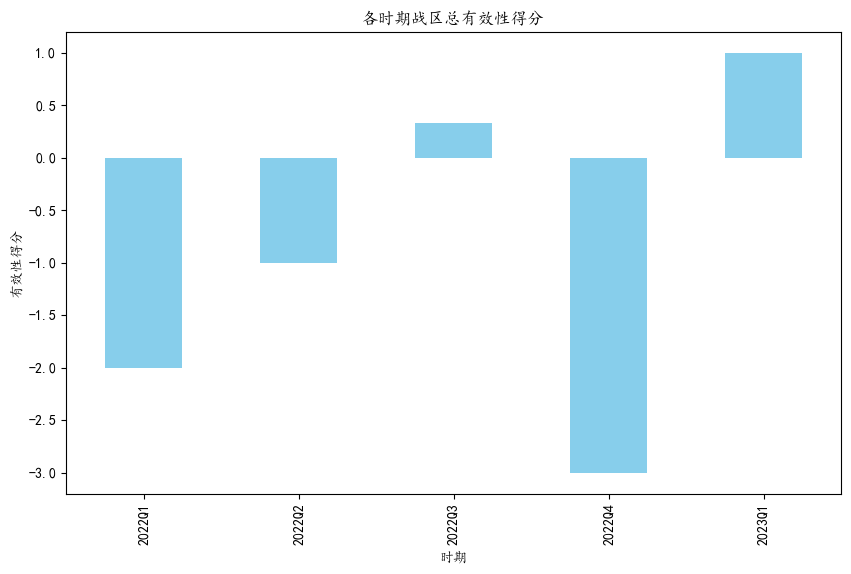

In [105]:
# Calculate the sum of effectiveness scores for each period
sum_effectiveness = effectiveness.drop(columns=['战区']).sum()
# Plot the bar chart
plt.figure(figsize=(10, 6))
sum_effectiveness.rename({'Period_1':'2022Q1','Period_2':'2022Q2',
                         'Period_3':'2022Q3','Period_4':'2022Q4',
                         'Period_5':'2023Q1'}).plot(kind='bar', color='skyblue')
plt.title("各时期战区总有效性得分")
plt.xlabel("时期")
plt.ylabel("有效性得分")
plt.show()

因此，我们可以总结，各战区业绩总体而言，对高管调职事件的反应普遍为积极，除了第3、5评估周期的小幅下降外

# 5.深度挖掘

## 5.1 各个Period的有效性得分是否显著？
- 该部分的意义在于确定各周期高管职位更换是否确实对战区业绩有显著影响
- 在这里使用置信区间与0的距离作为显著性的判定标准，具体地说，如果置信区间与0的最小距离大于某个阈值，我们就可以认为这个得分是显著的。

In [8]:
import numpy as np
import scipy.stats as stats

# Calculate the 95% confidence interval for the sum of effectiveness scores
confidence_level = 0.95
degrees_freedom = effectiveness.shape[0] - 1
sample_mean = effectiveness.drop(columns=['战区']).mean()
sample_standard_error = effectiveness.drop(columns=['战区']).std() / np.sqrt(effectiveness.shape[0])

confidence_intervals = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)

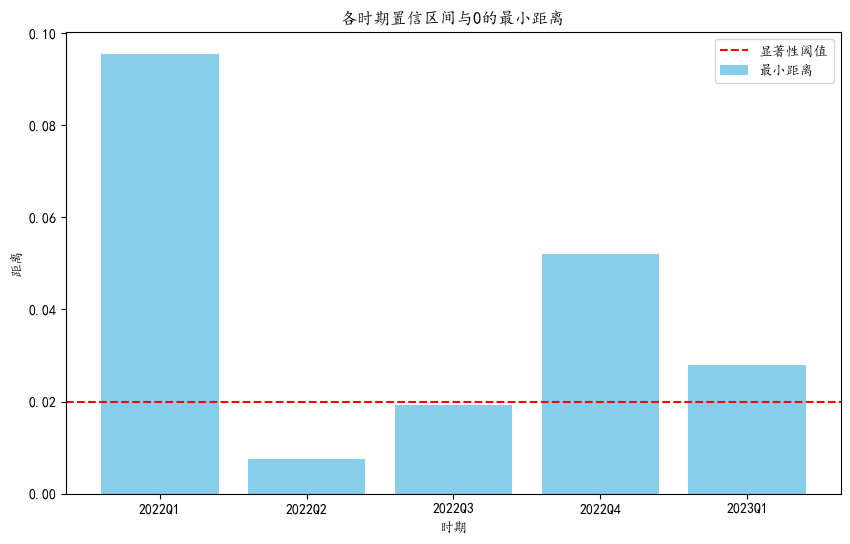

In [107]:
# Calculate the minimum distance of the confidence intervals from zero
lower_bound_distance = np.abs(confidence_intervals[0] - 0)
upper_bound_distance = np.abs(confidence_intervals[1] - 0)

# Minimum distance from 0 for each period
min_distance_from_zero = np.min([lower_bound_distance, upper_bound_distance], axis=0)
# Plotting the minimum distances from zero for each period with the threshold line

plt.figure(figsize=(10, 6))
plt.bar(columns1, min_distance_from_zero, color='skyblue', label='最小距离')
plt.axhline(0.02, color='red', linestyle='--', label='显著性阈值')
plt.title("各时期置信区间与0的最小距离")
plt.xlabel("时期")
plt.ylabel("距离")
plt.legend()
plt.show()


在此可以设定，置信区间与0的最小距离大于0.01，我们就可以认为随着战区高管职位的更换，该战区业绩有显著改变
- 那么只有Period_2是不认为显著的，其余我们都可以认为该效应很显著
- 本文建议使用0.01作为显著性阈值，这是一个相对保守的选择。这意味着只有当有效性得分与0的差异非常显著时，才会认为这是真实的，而不是随机的。这有助于公司做出更加稳健的决策。

# 6.研究小结

## 6.1 结论与建议
**1.持续跟进高管调职对战区门店业绩的影响**
<br>以往，公司可能没有深入研究高管调职对战区门店业绩的影响。但现在，研究明确显示了高管调职对业绩有积极的推动作用。因此，公司应该在未来对这一领域进行持续的跟进和研究，确保公司能够充分利用这一策略来推动业务增长。<br>
**2.权衡调职频率与稳定性**
<br>尽管高管调职对业绩有积极影响，但公司也需要考虑到调职的频率。过于频繁的高管调职可能会对战区的战略方向和团队稳定性带来不利影响。团队需要时间来适应新的领导和战略方向。因此，公司在决策时应该权衡调职的好处与可能带来的不稳定性。<br>
**3.完善战略沟通与培训机制**
<br>我们可以总体确定，高管调职对业绩有积极影响，但我们可以设想新任高管也面临一些阻碍，比如环境陌生、人力资源调动不充分。那么如果能够为新任高管提供适当的培训和资源，以确保他们可以迅速适应新的岗位和战区，将有助于提升调职成功率，提升业绩改善上限。<br>


## 6.2 后续改进方向
**1.连续调任的影响研究**
<br>本研究主要关注了单一高管调职事件对业绩的影响，但还需要深入了解连续多次调职对业绩的累积影响。例如，连续两次或三次调职是否会加强或减弱对业绩的影响，这是我们后续的研究方向之一。<br>
**2.业绩改善程度的精细量化**
<br>当前，我们主要采用了简单的、粗颗粒度的三元量化策略（0、1、2）。为了得到更细致的分析，可以考虑引入不同的量化级别，如将当月销售额、毛利额增长分别赋予不同权重，如果我们认为当月销售额增长的重要性高于毛利额增长，我们就可以赋予前者更高的权重。<br>
**3.不同层级高管调职影响的精细量化**
<br>不同层级的高管对战区业绩的影响可能不同。例如，总经理的调职可能比副总经理的调职对业绩有更大的影响。因此，可以考虑为不同层级的高管分配不同的权重，以更准确地反映其对业绩的影响。<br>
**4.数据的进一步完善**
<br>局限于数据量，当前我们只考虑了2022-2023Q1期间内的影响，但数据量的大小对研究结果的稳定性和可靠性有很大的影响。随着时间的推移和公司的发展，我们应该持续收集更多的数据，以便进行更长期、更全面的分析。<br>
